In [1]:
# Importing the necessary libraries

# For running inference on TF-Hub module
import tensorflow as tf
import tensorflow_hub as hub

# For downloading images
import matplotlib.pyplot as plt
import tempfile
from six import BytesIO
from six.moves.urllib.request import urlopen

# For drawing on images
import numpy as np
from PIL import Image, ImageColor, ImageDraw, ImageFont, ImageOps 

# For measuring inference time
import time


In [2]:
# Inception resnet version 2
module_handle = "https://tfhub.dev/google/faster_rcnn/openimages_v4/inception_resnet_v2/1"

In [3]:
# Model
model = hub.load(module_handle)

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [4]:
# Available signatures for this model
model.signatures.keys()

KeysView(_SignatureMap({'default': <ConcreteFunction pruned(images) at 0x7EFF2805DD10>}))

In [5]:
# Choosing 'default' signature for object detector
detector = model.signatures["default"]

In [6]:
# Function for displaying image
def display_image(image):
    
    fig = plt.figure(figsize = (20, 15))
    
    plt.grid(False)
    
    plt.imshow(image)


In [7]:
# Function for fetching image, resizing it and locally saving it 
def download_and_resize_image(url, new_width = 256, new_height = 256, display = True):
    
    # Creating temporary file with ".jpg" extention
    _, filename = tempfile.mkstemp(suffix = ".jpg")
    
    # Opening given URL
    response = urlopen(url)
    
    # Reading image fetched from URL
    image_data = response.read()
    
    # Putting image data in memory buffer
    image_data = BytesIO(image_data)
    
    # Opening image
    pil_image = Image.open(image_data)
    
    # Resizing image. Image will be cropped if aspect ratio is different.
    pil_image = ImageOps.fit(pil_image, (new_width, new_height), Image.ANTIALIAS)
    
    # Converting to RGB color-space
    pil_image_rgb = pil_image.convert("RGB")
    
    # Saving image to the temporary file
    pil_image_rgb.save(filename, format="JPEG", quality=90)
    
    print("Image downloaded to %s." % filename)
    
    if display:
        display_image(pil_image)

    
    return filename


In [9]:
def draw_bounding_box_on_image(image,
                               ymin,
                               xmin,
                               ymax,
                               xmax,
                               color,
                               font,
                               thickness = 4,
                               display_str_list = ()):
    
    draw = ImageDraw.Draw(image)
    im_width, im_height = image.size
    
    # Scaling bounding-box coordinates to the height and width of image
    (left, right, top, bottom) = (xmin * im_width, 
                                  xmax * im_width, 
                                  ymin * im_height, 
                                  ymax * im_height
                                 )
    
    # Defining four edges of detection box
    draw.line([(left, top), (left, bottom), (right, bottom), (right, top), (left, top)],
              width = thickness,
              fill = color
             )

    # If the total height of the display strings added to the top of the bounding
    # box exceeds the top of the image, stacking the strings below the bounding box
    # instead of above.
    display_str_heights = [font.getsize(ds)[1] for ds in display_str_list]
    
    # Each display_str has a top and bottom margin of 0.05x.
    total_display_str_height = (1 + 2 * 0.05) * sum(display_str_heights)

    if top > total_display_str_height:
        text_bottom = top
    else:
        text_bottom = top + total_display_str_height
        
    # Reversing list and print from bottom to top.
    for display_str in display_str_list[::-1]:
        text_width, text_height = font.getsize(display_str)
        margin = np.ceil(0.05 * text_height)
        draw.rectangle([(left, text_bottom - text_height - 2 * margin),
                        (left + text_width, text_bottom)],
                       fill = color)
        draw.text((left + margin, text_bottom - text_height - margin),
                  display_str,
                  fill = "black",
                  font = font
                 )
        text_bottom -= text_height - 2 * margin


In [10]:
def draw_boxes(image, boxes, class_names, scores, max_boxes = 10, min_score = 0.1):
    
    colors = list(ImageColor.colormap.values())

    try:
        font = ImageFont.truetype("/content/LiberationSansNarrow-Regular.ttf",
                                  25)
    except IOError:
        print("Font not found, using default font.")
        font = ImageFont.load_default()

    for i in range(min(boxes.shape[0], max_boxes)):
        
        # Displaying detection boxes that have the minimum score or higher
        if scores[i] >= min_score:
            
            ymin, xmin, ymax, xmax = tuple(boxes[i])
            
            display_str = "{}: {}%".format(class_names[i].decode("ascii"), 
                                           int(100 * scores[i])
                                          )
            
            color = colors[hash(class_names[i]) % len(colors)]
            
            image_pil = Image.fromarray(np.uint8(image)).convert("RGB")

            # draw one bounding box and overlay the class labels onto the image
            draw_bounding_box_on_image(image_pil,
                                       ymin,
                                       xmin,
                                       ymax,
                                       xmax,
                                       color,
                                       font,
                                       display_str_list=[display_str])
            
            np.copyto(image, np.array(image_pil))
        
    return image


In [11]:
def load_img(path):
    
    # Reading the file
    img = tf.io.read_file(path)
    
    # convert to a tensor
    img = tf.image.decode_jpeg(img, channels=3)
    
    return img


In [12]:
def run_detector(detector, path):
    
    # loading image-tensor from local file path
    img = load_img(path)

    # Adding a batch dimension in front of the tensor
    converted_img  = tf.image.convert_image_dtype(img, tf.float32)[tf.newaxis, ...]
    
    # Running inference using model
    start_time = time.time()
    result = detector(converted_img)
    end_time = time.time()

    # Saving results in a dictionary
    result = {key : value.numpy() for key, value in result.items()}

    # Printing results
    print("Found %d objects." % len(result["detection_scores"]))
    print("Inference time: ", end_time - start_time)

    # Drawing predicted boxes over image
    image_with_boxes = draw_boxes(img.numpy(), 
                                  result["detection_boxes"],
                                  result["detection_class_entities"], 
                                  result["detection_scores"]
                                 )

    # Displaying image
    display_image(image_with_boxes)


In [14]:
image_url = [
  "https://upload.wikimedia.org/wikipedia/commons/thumb/d/d0/Dhaka_Airport_Road_%2827150770395%29.jpg/1280px-Dhaka_Airport_Road_%2827150770395%29.jpg"
  ]


In [15]:
def detect_img(image_url):
    
    start_time = time.time()
    
    image_path = download_and_resize_image(image_url, 640, 480)
    
    run_detector(detector, image_path)
    
    end_time = time.time()
    
    print("Inference time:",end_time - start_time)


Image downloaded to /tmp/tmpx4sy5z0z.jpg.
Found 100 objects.
Inference time:  4.632167339324951
Inference time: 5.027191877365112


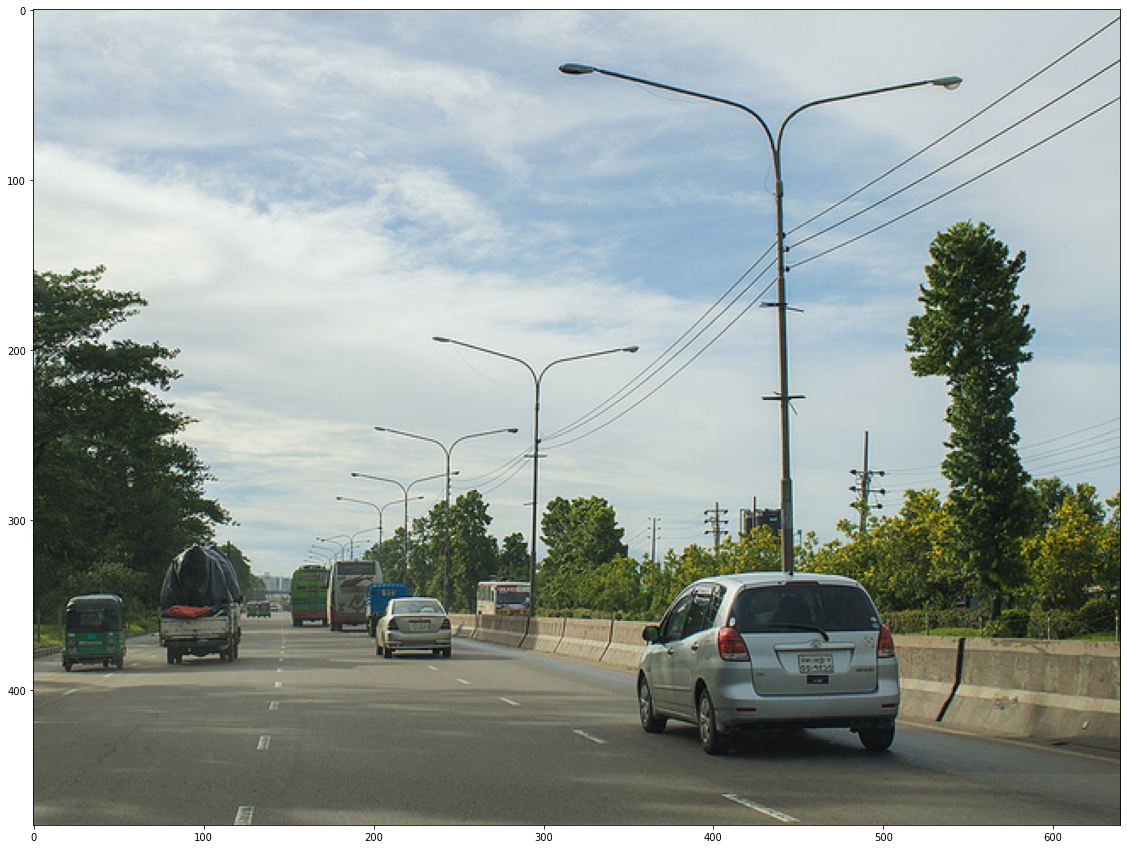

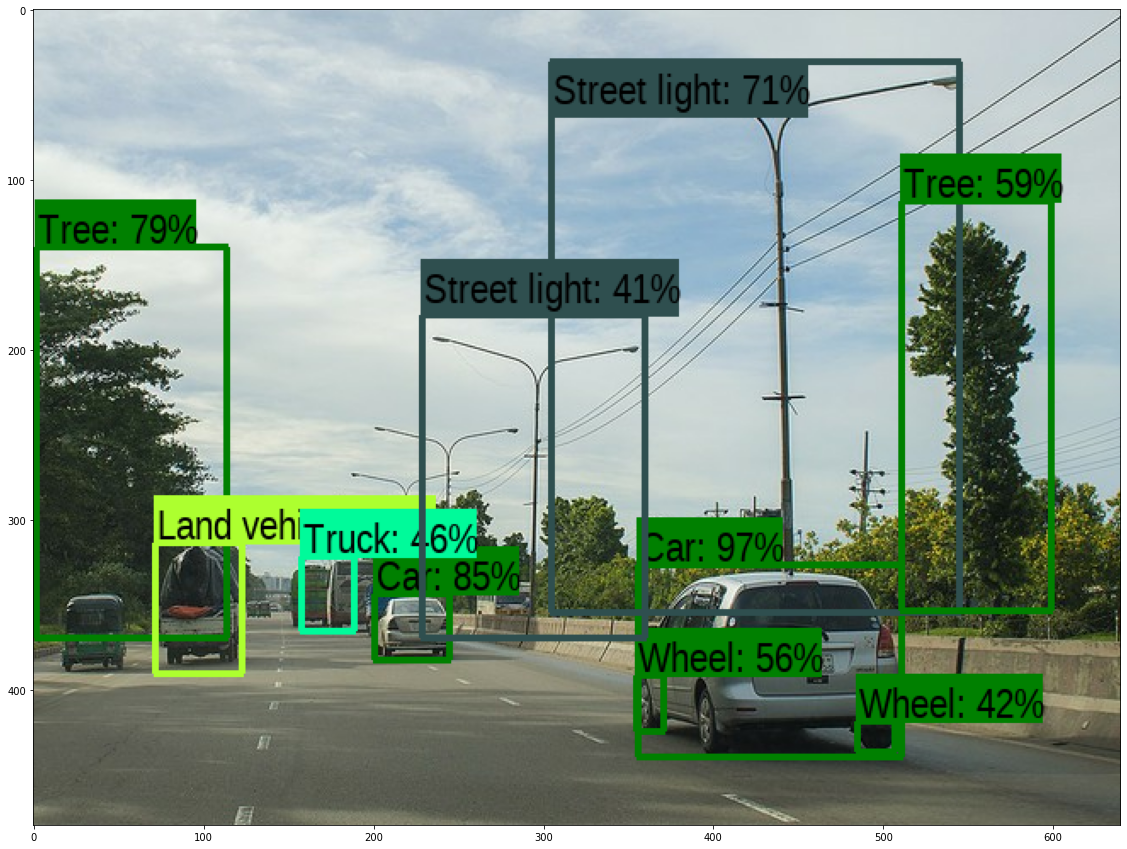

In [16]:
detect_img(image_url[0])